TODAY

In [1]:
from datetime import datetime

# Get today's date in 'YYYY-MM-DD' format
today_date = datetime.today().strftime('%Y-%m-%d')
print(today_date)

2025-06-03


Finance Data

In [2]:
import yfinance as yf

# Define parameters
symbol = 'MSFT'
start_date = '2000-01-01'
end_date = today_date
output_filename = f'{symbol}_daily_data.csv'

# Download data (make sure to not pass a list)
data = yf.download(symbol, start=start_date, end=end_date, interval='1d')

# Reset index to make 'Date' a column
data.reset_index(inplace=True)

# Save to clean CSV
data.to_csv(output_filename, index=False)



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
import pandas as pd
df = pd.read_csv(output_filename)
# Remove the first row (header row mistakenly read as data)
df = df.iloc[1:].reset_index(drop=True)

# Save the cleaned dataframe back to CSV
df.to_csv(output_filename, index=False)

Training an LSTM Model with Stock Data

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

2025-06-03 12:38:59.202476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748954339.371075   59459 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748954339.416496   59459 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748954339.939615   59459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748954339.939662   59459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748954339.939665   59459 computation_placer.cc:177] computation placer alr

In [5]:
# Load your CSV (must have 'Close' column)
df = pd.read_csv(output_filename)

# Ensure only numerical data
data = df[['Close']].dropna().values

In [6]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [7]:
# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 60  # e.g. 60 days
X, y = create_sequences(scaled_data, time_steps)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Train-test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Fine-tuned model architecture
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile with different optimizer and learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Enhanced callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001)
checkpoint = ModelCheckpoint('best_model_tuned.h5', save_best_only=True, monitor='val_loss')

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


2025-06-03 12:39:03.708510: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/workspaces/Stock-Market-Prediction-AI-Model/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    verbose=1
)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate
mae = mean_absolute_error(y_test_rescaled, predictions)
mse = mean_squared_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}')



Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0012 - mae: 0.0196

159/159 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - loss: 0.0012 - mae: 0.0196 - val_loss: 0.0123 - val_mae: 0.0967
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 1.3022e-04 - mae: 0.0058

159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - loss: 1.3006e-04 - mae: 0.0058 - val_loss: 0.0084 - val_mae: 0.0755
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 7.3885e-05 - mae: 0.0051

159/159 ━━━━━━━━━━━━━━━━━━━━ 42s 262ms/step - loss: 7.3882e-05 - mae: 0.0051 - val_loss: 0.0068 - val_mae: 0.0674
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 7.4089e-05 - mae: 0.0051

159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - loss: 7.4065e-05 - mae: 0.0051 - val_loss: 0.0044 - val_mae: 0.0537
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - loss: 7.2134e-05 - mae: 0.0047 - val_loss: 0.0051 - val_mae: 0.0572
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - loss: 5.7264e-05 - mae: 0.0044 - val_loss: 0.0052 - val_mae: 0.0590
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 5.3622e-05 - mae: 0.0046

159/159 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - loss: 5.3648e-05 - mae: 0.0046 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - loss: 6.4604e-05 - mae: 0.0050 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - loss: 7.0787e-05 - mae: 0.0052 - val_loss: 0.0042 - val_mae: 0.0514
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 6.7198e-05 - mae: 0.0048

159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - loss: 6.7155e-05 - mae: 0.0048 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - loss: 7.1725e-05 - mae: 0.0054 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 12/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - loss: 5.8380e-05 - mae: 0.0048 - val_loss: 0.0014 - val_mae: 0.0287
Epoch 13/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - loss: 6.8569e-05 - mae: 0.0052 - val_loss: 0.0026 - val_mae: 0.0391
Epoch 14/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - loss: 6.2210e-05 - mae: 0.0052 - val_loss: 0.0029 - val_mae: 0.0433
Epoch 15/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - loss: 5.2885e-05 - mae: 0.0045 - val_loss: 0.0071 - val_mae: 0.0725
Epoch 16/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - loss: 4.3616e-05 - mae: 0.0043 - val_loss: 0.0067 - val_mae: 0.0709
Epoch 17/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 79s 243ms/step - loss: 4.7715e-05 - mae: 0.0044 - val_loss: 0.0058 - val_mae: 0.06

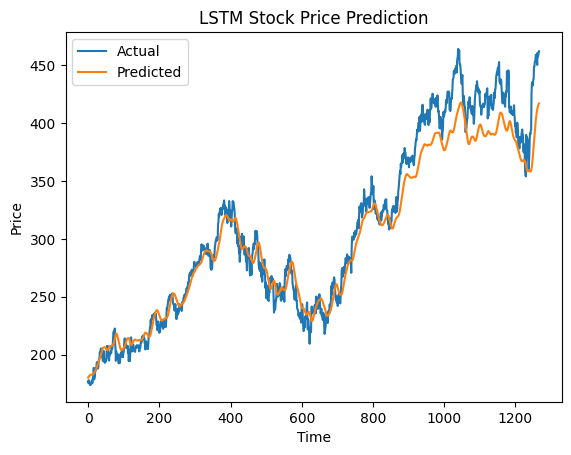

In [10]:
# Plot results
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()